In [109]:
# For local use, replace google.colab with standard file handling
import os
import cv2
import numpy as np
import mediapipe as mp

In [110]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

## Visualization utilities

In [111]:
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_tesselation_style()
        )
        
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style()
        )
        
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_iris_connections_style()
        )

    return annotated_image

In [112]:
def plot_face_blendshapes_bar_graph(face_blendshapes):

    # Extract the face blendshape categories and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12,12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f'{score:.4f}', va='top')

    ax.set_xlabel('Score')
    ax.set_title('Face Blendshapes')
    plt.tight_layout()
    plt.show()

## Set test image

In [113]:
import os
import cv2
import numpy as np

In [114]:
def load_local_image(image_path):
    """Load image from local file path with proper transparency handling"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Read image with alpha channel (RGBA)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    print(f"Original image shape: {image.shape}")  # Debug info
    
    # Handle different channel counts
    if len(image.shape) == 3:
        if image.shape[2] == 4:  # BGRA format
            print("Processing RGBA image...")
            # Convert BGRA to RGBA
            image_rgba = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
            
            # Create a white background
            height, width = image_rgba.shape[:2]
            background = np.ones((height, width, 3), dtype=np.uint8) * 255
            
            # Extract alpha channel
            alpha = image_rgba[:, :, 3] / 255.0
            
            # Blend foreground with white background using alpha
            for c in range(3):
                background[:, :, c] = (alpha * image_rgba[:, :, c] + 
                                     (1 - alpha) * background[:, :, c])
            
            image_rgb = background.astype(np.uint8)
            print("Applied alpha blending with white background")
            
        elif image.shape[2] == 3:  # BGR format
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print("Converted BGR to RGB")
        else:
            image_rgb = image
    else:
        # Grayscale
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        print("Converted grayscale to RGB")
    
    print(f"Final image shape: {image_rgb.shape}")
    return image_rgb

In [115]:
# Display function replacements for cv2_imshow (Colab-specific)
import matplotlib.pyplot as plt

def show_image(image, title="Image", figsize=(10, 8)):
    """Display image using matplotlib - replacement for cv2_imshow"""
    plt.figure(figsize=figsize)
    
    # Handle different image formats
    if len(image.shape) == 3:
        # Color image - convert BGR to RGB if needed
        if image.shape[2] == 3:
            # Assume BGR format from OpenCV
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image
        plt.imshow(image_rgb)
    else:
        # Grayscale image
        plt.imshow(image, cmap='gray')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

In [116]:
image_path = "../image_processing/out_sample/clipped_images_fg/8104_fg.png"

image = load_local_image(image_path)

Original image shape: (1169, 843, 4)
Processing RGBA image...
Applied alpha blending with white background
Final image shape: (1169, 843, 3)


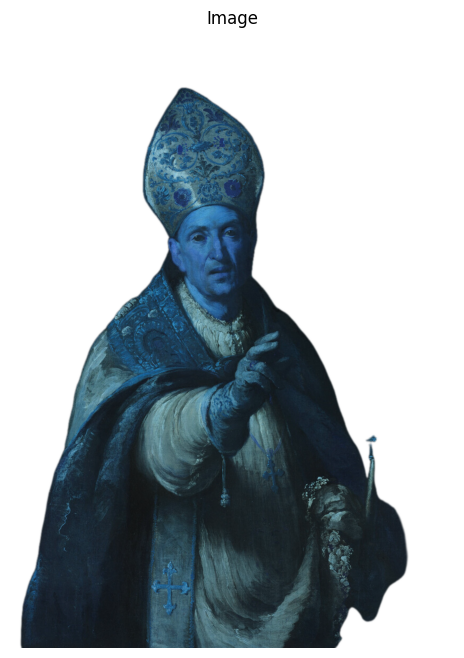

In [117]:
show_image(image)

## Running inference and visualizing the results

In [118]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

Original image shape: (1169, 843, 4)
Processing RGBA image...
Applied alpha blending with white background
Final image shape: (1169, 843, 3)


I0000 00:00:1757444714.354497    3814 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1757444714.354762    3814 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1757444714.358563   35480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1757444714.365364   35500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  wa

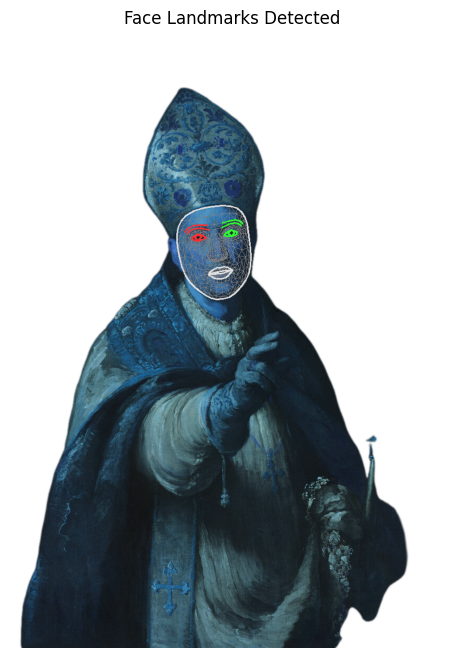

In [119]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image using our local function
image_rgb = load_local_image(image_path)
image_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image_mp)

# STEP 5: Process the detection result. In this case, visualize it.
if detection_result.face_landmarks:
    annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
    show_image(annotated_image, "Face Landmarks Detected")
else:
    print("No face landmarks detected")
    show_image(image_rgb, "Original Image - No Face Detected")

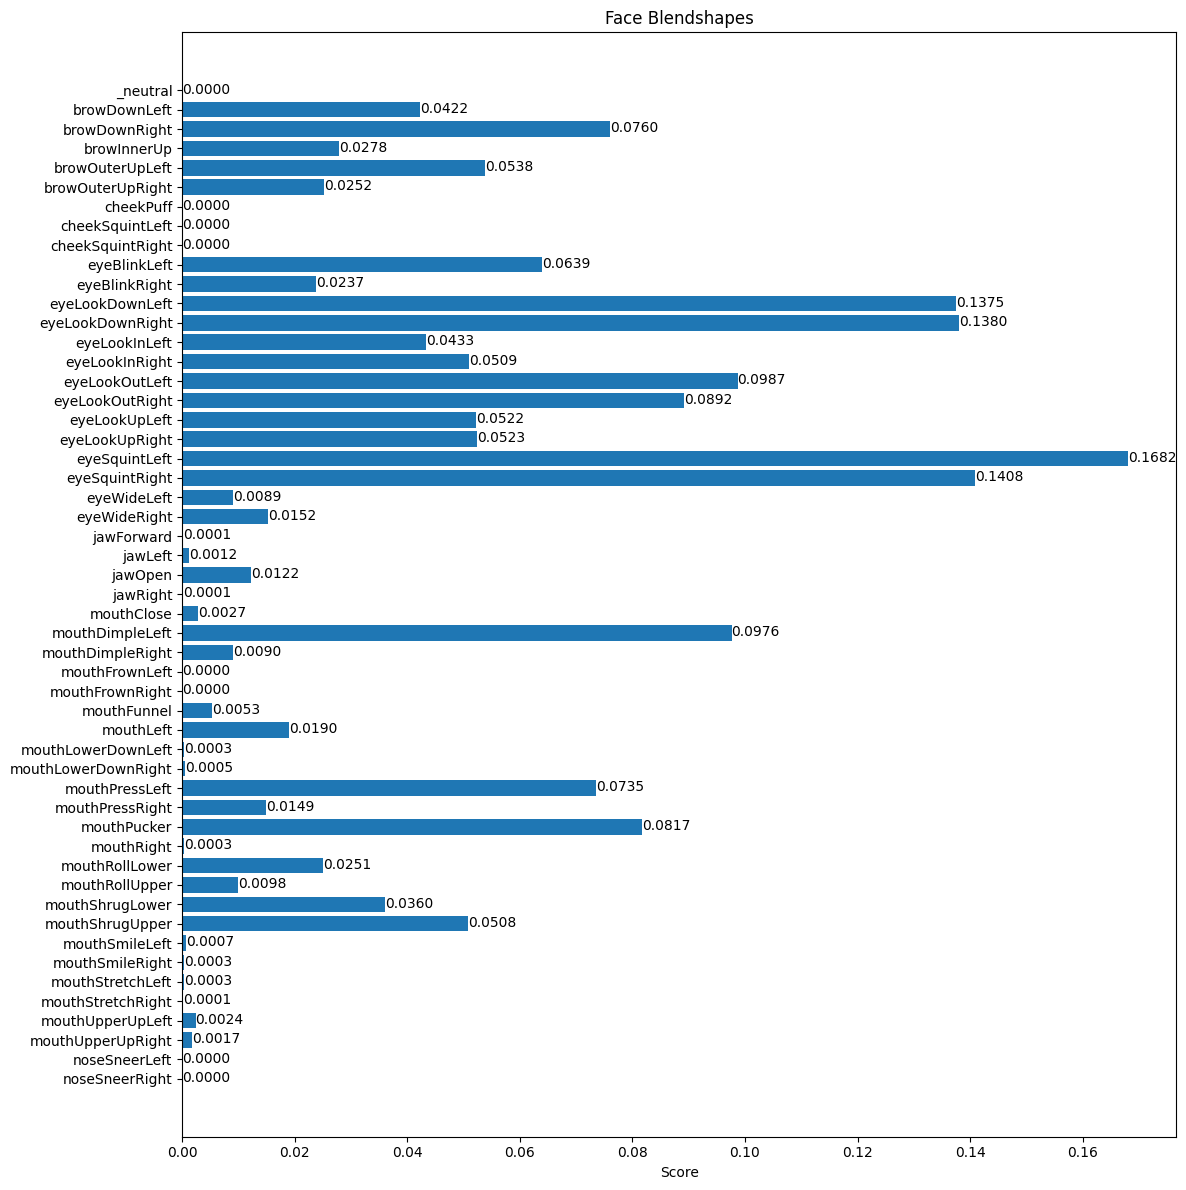

In [120]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [121]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.88215566e-01, -1.36176646e-01,  6.99026063e-02,
        -3.39416671e+00],
       [ 1.40770987e-01,  9.87864435e-01, -6.56346828e-02,
         1.82205105e+01],
       [-6.01163805e-02,  7.47014508e-02,  9.95392501e-01,
        -1.04366196e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


총 랜드마크 개수: 478

=== 첫 10개 랜드마크 샘플 ===
Index   0: x=0.473, y=0.383, z=-0.018
Index   1: x=0.469, y=0.368, z=-0.035
Index   2: x=0.470, y=0.373, z=-0.018
Index   3: x=0.460, y=0.349, z=-0.027
Index   4: x=0.468, y=0.362, z=-0.037
Index   5: x=0.467, y=0.354, z=-0.035
Index   6: x=0.464, y=0.335, z=-0.017
Index   7: x=0.412, y=0.337, z=0.006
Index   8: x=0.461, y=0.320, z=-0.013
Index   9: x=0.460, y=0.313, z=-0.015


/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/envs/portrait_outline/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joonhyoung-lee/miniconda3/e

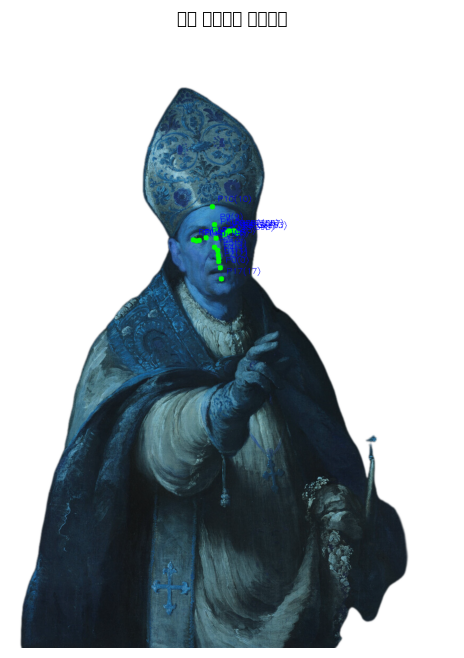


=== 테스트한 주요 포인트 좌표 ===
Index   0: 픽셀( 398,  447) | 정규화(0.473, 0.383)
Index   1: 픽셀( 395,  430) | 정규화(0.469, 0.368)
Index   2: 픽셀( 395,  435) | 정규화(0.470, 0.373)
Index   3: 픽셀( 387,  408) | 정규화(0.460, 0.349)
Index   4: 픽셀( 394,  423) | 정규화(0.468, 0.362)
Index   5: 픽셀( 393,  414) | 정규화(0.467, 0.354)
Index   6: 픽셀( 390,  391) | 정규화(0.464, 0.335)
Index   7: 픽셀( 347,  394) | 정규화(0.412, 0.337)
Index   8: 픽셀( 388,  374) | 정규화(0.461, 0.320)
Index   9: 픽셀( 387,  365) | 정규화(0.460, 0.313)


In [122]:
# 실제 랜드마크 데이터 분석
if detection_result.face_landmarks:
    landmarks = detection_result.face_landmarks[0]
    print(f"총 랜드마크 개수: {len(landmarks)}")
    
    # 몇 개의 랜드마크 포인트 샘플 출력
    print("\n=== 첫 10개 랜드마크 샘플 ===")
    for i in range(min(10, len(landmarks))):
        landmark = landmarks[i]
        print(f"Index {i:3d}: x={landmark.x:.3f}, y={landmark.y:.3f}, z={landmark.z:.3f}")
    
    # 이미지에서 특정 포인트들을 시각적으로 확인하기 위한 함수
    def visualize_specific_points(image, landmarks, point_indices, labels):
        """특정 랜드마크 포인트들을 이미지에 표시"""
        annotated = image.copy()
        height, width = image.shape[:2]
        
        for i, idx in enumerate(point_indices):
            if idx < len(landmarks):
                landmark = landmarks[idx]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                
                # 포인트 그리기
                cv2.circle(annotated, (x, y), 5, (0, 255, 0), -1)
                # 라벨 추가
                cv2.putText(annotated, f"{labels[i]}({idx})", (x+10, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        return annotated
    
    # 알려진 주요 랜드마크 포인트들을 테스트해보기
    # MediaPipe Face Mesh의 일반적인 주요 포인트들
    test_points = [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  # 얼굴 윤곽 상단
        33, 7, 163, 144, 145, 153, 154, 155, 133,  # 오른쪽 눈 주변
        362, 398, 384, 385, 386, 387, 388, 466, 263,  # 왼쪽 눈 주변
        61, 84, 17, 314, 405, 320, 307, 375, 321, 308, 324, 318,  # 입 주변
        10, 151, 9, 10, 151, 175,  # 코와 턱
        234, 93, 132, 58, 172, 136, 150, 149, 176, 148, 152, 377, 400, 378, 379, 365, 397, 288, 361, 323  # 기타 주요점
    ]
    
    # 중복 제거
    test_points = list(set(test_points))[:20]  # 처음 20개만
    labels = [f"P{i}" for i in test_points]
    
    # 테스트 포인트들 시각화
    test_image = visualize_specific_points(image_rgb, landmarks, test_points, labels)
    show_image(test_image, "주요 랜드마크 포인트들", figsize=(12, 8))
    
    print(f"\n=== 테스트한 주요 포인트 좌표 ===")
    for idx in test_points[:10]:  # 처음 10개만 출력
        if idx < len(landmarks):
            landmark = landmarks[idx]
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])
            print(f"Index {idx:3d}: 픽셀({x:4d}, {y:4d}) | 정규화({landmark.x:.3f}, {landmark.y:.3f})")
else:
    print("얼굴이 감지되지 않았습니다.")

In [123]:
# 주요 얼굴 특징점들을 더 체계적으로 찾아보기
def find_key_landmarks(landmarks, image_shape):
    """주요 얼굴 특징점들의 인덱스를 찾고 좌표를 반환"""
    
    # 알려진 MediaPipe Face Mesh 주요 포인트들 (공식 문서 기준)
    key_points = {
        # 눈 관련
        'left_eye_center': 468,   # 왼쪽 눈 중심 (iris)
        'right_eye_center': 473,  # 오른쪽 눈 중심 (iris)
        'left_eye_inner': 133,    # 왼쪽 눈 안쪽 모서리
        'left_eye_outer': 33,     # 왼쪽 눈 바깥쪽 모서리  
        'right_eye_inner': 362,   # 오른쪽 눈 안쪽 모서리
        'right_eye_outer': 263,   # 오른쪽 눈 바깥쪽 모서리
        
        # 코 관련
        'nose_tip': 1,            # 코끝
        'nose_bridge': 6,         # 코 다리
        'nose_left': 31,          # 코 왼쪽
        'nose_right': 261,        # 코 오른쪽
        
        # 입 관련  
        'mouth_left': 61,         # 입 왼쪽 모서리
        'mouth_right': 291,       # 입 오른쪽 모서리
        'mouth_center_top': 13,   # 윗입술 중앙
        'mouth_center_bottom': 14, # 아랫입술 중앙
        
        # 얼굴 윤곽
        'chin': 175,              # 턱
        'forehead': 9,            # 이마
        'left_cheek': 116,        # 왼쪽 볼
        'right_cheek': 345,       # 오른쪽 볼
        
        # 귀 근처 (정확한 귀는 아니지만 귀 근처 얼굴 윤곽)
        'left_face_side': 234,    # 왼쪽 얼굴 측면
        'right_face_side': 454,   # 오른쪽 얼굴 측면
    }
    
    results = {}
    height, width = image_shape[:2]
    
    for name, idx in key_points.items():
        if idx < len(landmarks):
            landmark = landmarks[idx]
            pixel_x = int(landmark.x * width)
            pixel_y = int(landmark.y * height)
            
            results[name] = {
                'index': idx,
                'pixel_x': pixel_x,
                'pixel_y': pixel_y,
                'norm_x': landmark.x,
                'norm_y': landmark.y,
                'z': landmark.z if hasattr(landmark, 'z') else 0
            }
    
    return results

# 주요 특징점들 추출
key_landmarks = find_key_landmarks(landmarks, image.shape)

print("=== 주요 얼굴 특징점 좌표 ===")
print("특징점                 인덱스   픽셀좌표       정규화좌표      Z값")
print("-" * 70)

for feature_name, coords in key_landmarks.items():
    print(f"{feature_name:20} {coords['index']:3d}   ({coords['pixel_x']:4d},{coords['pixel_y']:4d})   ({coords['norm_x']:.3f},{coords['norm_y']:.3f})   {coords['z']:.3f}")

# 주요 측정값 계산
if 'left_eye_center' in key_landmarks and 'right_eye_center' in key_landmarks:
    left_eye = key_landmarks['left_eye_center']
    right_eye = key_landmarks['right_eye_center']
    eye_distance = ((left_eye['pixel_x'] - right_eye['pixel_x'])**2 + 
                   (left_eye['pixel_y'] - right_eye['pixel_y'])**2)**0.5
    eye_center_y = (left_eye['pixel_y'] + right_eye['pixel_y']) // 2
    print(f"\n=== 주요 측정값 ===")
    print(f"눈 사이 거리: {eye_distance:.1f} 픽셀")
    print(f"눈 높이 라인: y = {eye_center_y} 픽셀")

if 'nose_tip' in key_landmarks:
    face_center_x = key_landmarks['nose_tip']['pixel_x'] 
    print(f"얼굴 중심 세로선: x = {face_center_x} 픽셀")

if 'mouth_left' in key_landmarks and 'mouth_right' in key_landmarks:
    mouth_left = key_landmarks['mouth_left']
    mouth_right = key_landmarks['mouth_right'] 
    mouth_width = abs(mouth_left['pixel_x'] - mouth_right['pixel_x'])
    print(f"입 너비: {mouth_width} 픽셀")

if 'chin' in key_landmarks and 'forehead' in key_landmarks:
    chin = key_landmarks['chin']
    forehead = key_landmarks['forehead']
    face_height = abs(chin['pixel_y'] - forehead['pixel_y'])
    print(f"얼굴 높이: {face_height} 픽셀")

=== 주요 얼굴 특징점 좌표 ===
특징점                 인덱스   픽셀좌표       정규화좌표      Z값
----------------------------------------------------------------------
left_eye_center      468   ( 356, 389)   (0.423,0.333)   0.001
right_eye_center     473   ( 419, 381)   (0.498,0.326)   0.001
left_eye_inner       133   ( 371, 390)   (0.441,0.334)   0.004
left_eye_outer        33   ( 344, 392)   (0.409,0.336)   0.008
right_eye_inner      362   ( 405, 386)   (0.481,0.331)   0.007
right_eye_outer      263   ( 430, 381)   (0.511,0.326)   0.014
nose_tip               1   ( 395, 430)   (0.469,0.368)   -0.035
nose_bridge            6   ( 390, 391)   (0.464,0.335)   -0.017
nose_left             31   ( 340, 401)   (0.404,0.344)   0.010
nose_right           261   ( 436, 388)   (0.518,0.332)   0.017
mouth_left            61   ( 376, 460)   (0.446,0.394)   0.000
mouth_right          291   ( 421, 452)   (0.500,0.387)   0.004
mouth_center_top      13   ( 399, 454)   (0.473,0.389)   -0.012
mouth_center_bottom   14   ( 399, 4

Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61→308): 2


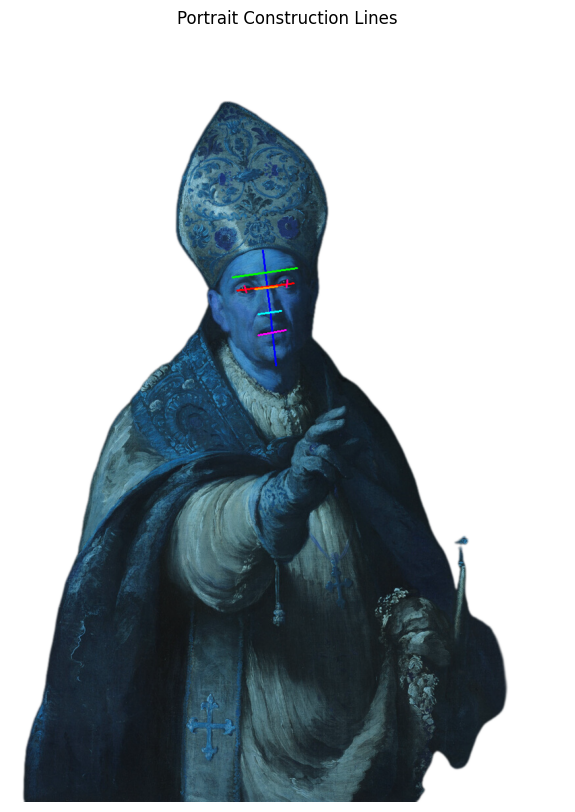


=== Construction Lines Applied ===
Red: Vertical Center Line
Green: Eyebrow Line
Blue/Light Blue/Purple: Eye Lines
Yellow: Nose Line
Magenta: Mouth Line


In [124]:
# Portrait Drawing Construction Lines Implementation
# Based on Portrait_drawing_outlines_connection_rule.md

def draw_construction_lines(image, landmarks, color=(0, 255, 0), thickness=2):
    """
    Draw portrait construction lines based on MediaPipe face landmarks
    following the rules from Portrait_drawing_outlines_connection_rule.md
    """
    if not landmarks:
        return image
    
    annotated = image.copy()
    height, width = image.shape[:2]
    
    def get_pixel_coords(landmark_idx):
        """Convert normalized landmark coordinates to pixel coordinates"""
        if landmark_idx >= len(landmarks):
            return None
        landmark = landmarks[landmark_idx]
        return (int(landmark.x * width), int(landmark.y * height))
    
    def draw_line_between_points(point_indices, line_color=None):
        """Draw line connecting multiple points"""
        if line_color is None:
            line_color = color
            
        points = []
        for idx in point_indices:
            point = get_pixel_coords(idx)
            if point:
                points.append(point)
        
        # Draw line through all points
        for i in range(len(points) - 1):
            cv2.line(annotated, points[i], points[i + 1], line_color, thickness)
        
        return points
    
    # 1. Vertical Center Line [10→168→4→152]
    # Description: contour from the tip of the chin to the ear
    vertical_points = draw_line_between_points([10, 168, 4, 152], (255, 0, 0))  # Red
    print(f"Vertical Center Line points: {len(vertical_points)}")
    
    # 2. Eyebrow Line [63→293] 
    # Description: The line connecting the two eyebrows
    eyebrow_points = draw_line_between_points([63, 293], (0, 255, 0))  # Green
    print(f"Eyebrow Line points: {len(eyebrow_points)}")
    
    # 3. Eye Line [33→263], [133→362], [145→159], [374→386]
    # Description: The line connecting the two eyes (most important baseline)
    eye_line_1 = draw_line_between_points([33, 263], (0, 0, 255))  # Blue - outer eye corners
    eye_line_2 = draw_line_between_points([133, 362], (0, 150, 255))  # Light blue - inner eye corners
    eye_line_3 = draw_line_between_points([145, 159], (100, 0, 255))  # Purple
    eye_line_4 = draw_line_between_points([374, 386], (150, 0, 255))  # Purple
    print(f"Eye Lines: {len(eye_line_1)}, {len(eye_line_2)}, {len(eye_line_3)}, {len(eye_line_4)}")
    
    # 4. Nose Line [48→278]
    # Description: The line that determines the width of the nose tip
    nose_points = draw_line_between_points([48, 278], (255, 255, 0))  # Yellow
    print(f"Nose Line points: {len(nose_points)}")
    
    # 5. Mouth Line [61→308] (but 308 might not exist, try 291 which is mouth_right)
    # Description: A line that defines the width and height of the mouth
    # Let's try the original 308 first, then fallback to 291
    try:
        mouth_points = draw_line_between_points([61, 308], (255, 0, 255))  # Magenta
        print(f"Mouth Line points (61→308): {len(mouth_points)}")
    except:
        # Fallback to known mouth_right index 291
        mouth_points = draw_line_between_points([61, 291], (255, 0, 255))  # Magenta
        print(f"Mouth Line points (61→291): {len(mouth_points)}")
    
    # Add labels for each construction line
    label_color = (255, 255, 255)  # White
    cv2.putText(annotated, "Vertical Center", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Eyebrow Line", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Eye Lines", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Nose Line", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    cv2.putText(annotated, "Mouth Line", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
    
    return annotated

# Apply construction lines to the detected face
if detection_result.face_landmarks:
    construction_image = draw_construction_lines(image_rgb, landmarks)
    show_image(construction_image, "Portrait Construction Lines", figsize=(14, 10))
    
    print("\n=== Construction Lines Applied ===")
    print("Red: Vertical Center Line")
    print("Green: Eyebrow Line") 
    print("Blue/Light Blue/Purple: Eye Lines")
    print("Yellow: Nose Line")
    print("Magenta: Mouth Line")
else:
    print("No face landmarks detected for construction lines")

In [125]:
# ==========================================
# Wireframe Portrait Generation Functions
# ==========================================

# Method 1: Face Mask-based Removal
def create_face_outline_only(image, landmarks, construction_lines_image):
    """
    얼굴 부분을 제거하고 mesh와 construction lines만 남기기 (마스크 기반)
    
    Args:
        image: 원본 이미지
        landmarks: MediaPipe face landmarks
        construction_lines_image: construction lines가 그려진 이미지
    
    Returns:
        result: RGBA 이미지 (얼굴 부분 투명)
        mask: 사용된 마스크
    """
    height, width = image.shape[:2]
    
    # 1. 얼굴 윤곽 포인트들로 마스크 생성 (MediaPipe Face Mesh의 face oval 랜드마크)
    face_oval_points = [
        # 얼굴 외곽 윤곽선 랜드마크 인덱스들
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109
    ]
    
    # 랜드마크를 픽셀 좌표로 변환
    face_points = []
    for idx in face_oval_points:
        if idx < len(landmarks):
            landmark = landmarks[idx]
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            face_points.append((x, y))
    
    # 2. 얼굴 윤곽으로 마스크 생성
    mask = np.zeros((height, width), dtype=np.uint8)
    if len(face_points) > 0:
        face_contour = np.array(face_points, dtype=np.int32)
        cv2.fillPoly(mask, [face_contour], 255)
        
        # 마스크를 약간 축소해서 경계선이 잘 보이도록
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=2)
    
    # 3. RGBA 이미지 생성 (투명도 채널 추가)
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # 4. 얼굴 영역을 투명하게 만들기
    result[mask > 0, 3] = 0  # 알파 채널을 0으로 (완전 투명)
    
    return result, mask

print("✅ Method 1: Face Mask-based Removal function implemented")

✅ Method 1: Face Mask-based Removal function implemented


In [126]:
# Method 2: Color Difference-based Removal
def remove_face_keep_lines(construction_lines_image, original_image, threshold=30):
    """
    원본 이미지와 비교해서 변화가 적은 부분(얼굴)은 투명하게 만들기
    
    Args:
        construction_lines_image: construction lines가 그려진 이미지
        original_image: 원본 이미지
        threshold: 변화 감지 임계값 (높을수록 더 많은 부분이 제거됨)
    
    Returns:
        result: RGBA 이미지 (얼굴 부분 투명)
        line_mask: 선 영역 마스크
    """
    # 1. 원본 이미지와 construction lines 이미지의 차이 계산
    diff = cv2.absdiff(construction_lines_image, original_image)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    
    # 2. 변화가 큰 부분(선들)만 마스크로 만들기
    _, line_mask = cv2.threshold(diff_gray, threshold, 255, cv2.THRESH_BINARY)
    
    # 3. 선 마스크를 조금 확장해서 선이 잘 보이도록
    kernel = np.ones((3,3), np.uint8)
    line_mask = cv2.dilate(line_mask, kernel, iterations=1)
    
    # 4. RGBA 이미지 생성
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # 5. 선이 아닌 부분을 투명하게 만들기
    result[line_mask == 0, 3] = 0
    
    return result, line_mask

print("✅ Method 2: Color Difference-based Removal function implemented")

✅ Method 2: Color Difference-based Removal function implemented


In [127]:
# Method 3: Color-based Filtering
def extract_colored_lines_only(construction_lines_image, colors_to_keep=None, tolerance=20):
    """
    특정 색상의 선들만 남기고 나머지는 투명하게 만들기
    
    Args:
        construction_lines_image: construction lines가 그려진 이미지
        colors_to_keep: 보존할 색상 리스트 (RGB)
        tolerance: 색상 허용 범위
    
    Returns:
        result: RGBA 이미지 (선 색상만 보존)
        keep_mask: 보존된 영역 마스크
    """
    if colors_to_keep is None:
        # construction lines에서 사용한 색상들
        colors_to_keep = [
            (255, 0, 0),    # Red - Vertical Center
            (0, 255, 0),    # Green - Eyebrow Line
            (0, 0, 255),    # Blue - Eye Lines
            (0, 150, 255),  # Light Blue - Eye Lines
            (100, 0, 255),  # Purple - Eye Lines
            (150, 0, 255),  # Purple - Eye Lines
            (255, 255, 0),  # Yellow - Nose Line
            (255, 0, 255),  # Magenta - Mouth Line
            (255, 255, 255) # White - Labels
        ]
    
    # RGBA 이미지 생성
    result = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2RGBA)
    
    # 마스크 생성 (모든 픽셀을 투명하게 시작)
    keep_mask = np.zeros(construction_lines_image.shape[:2], dtype=bool)
    
    # 각 색상에 대해 허용 범위 설정
    for color in colors_to_keep:
        # 색상 범위 마스크 생성
        lower = np.array([max(0, c - tolerance) for c in color])
        upper = np.array([min(255, c + tolerance) for c in color])
        
        color_mask = cv2.inRange(construction_lines_image, lower, upper)
        keep_mask = keep_mask | (color_mask > 0)
    
    # MediaPipe mesh lines도 보존하기 위해 특별히 처리
    # mesh는 얇은 선이므로 더 넓은 허용 범위로 탐지
    gray = cv2.cvtColor(construction_lines_image, cv2.COLOR_RGB2GRAY)
    _, mesh_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # 어두운 선들 찾기
    
    # mesh 선들을 keep_mask에 추가
    keep_mask = keep_mask | (mesh_mask > 0)
    
    # 보존할 색상이 아닌 부분을 투명하게 만들기
    result[~keep_mask, 3] = 0
    
    return result, keep_mask.astype(np.uint8) * 255

print("✅ Method 3: Color-based Filtering function implemented")

✅ Method 3: Color-based Filtering function implemented


In [128]:
# Unified Wireframe Portrait Generation Function
def create_wireframe_portrait(image_rgb, landmarks, detection_result, method='face_mask', **kwargs):
    """
    얼굴의 wireframe(선화) 버전 생성
    
    Args:
        image_rgb: 원본 RGB 이미지
        landmarks: MediaPipe face landmarks
        detection_result: MediaPipe detection result
        method: 사용할 방법 ('face_mask', 'color_diff', 'color_filter')
        **kwargs: 각 방법별 추가 매개변수
            - face_mask: 매개변수 없음
            - color_diff: threshold (기본값: 30)
            - color_filter: colors_to_keep, tolerance (기본값: 20)
    
    Returns:
        result: RGBA wireframe 이미지
        mask: 사용된 마스크
        construction_image: construction lines가 그려진 중간 이미지
        mesh_image: mesh가 추가된 중간 이미지
    """
    # 1. Construction lines 그리기
    construction_image = draw_construction_lines(image_rgb, landmarks)
    
    # 2. Face mesh 그리기 (더 얇은 선으로)
    mesh_image = draw_landmarks_on_image(construction_image, detection_result)
    
    # 3. 선택한 방법으로 얼굴 부분 제거
    if method == 'face_mask':
        result, mask = create_face_outline_only(image_rgb, landmarks, mesh_image)
        print("✅ Face Mask 방법 사용")
        
    elif method == 'color_diff':
        threshold = kwargs.get('threshold', 30)
        result, mask = remove_face_keep_lines(mesh_image, image_rgb, threshold)
        print(f"✅ Color Difference 방법 사용 (threshold: {threshold})")
    
    elif method == 'color_filter':
        colors_to_keep = kwargs.get('colors_to_keep', None)
        tolerance = kwargs.get('tolerance', 20)
        result, mask = extract_colored_lines_only(mesh_image, colors_to_keep, tolerance)
        print(f"✅ Color Filter 방법 사용 (tolerance: {tolerance})")
    
    else:
        print(f"❌ 알 수 없는 방법: {method}. 기본 RGBA 변환만 수행.")
        result = cv2.cvtColor(mesh_image, cv2.COLOR_RGB2RGBA)
        mask = None
    
    return result, mask, construction_image, mesh_image

print("✅ Unified wireframe portrait generation function implemented")

✅ Unified wireframe portrait generation function implemented


In [129]:
# RGBA 이미지 표시를 위한 헬퍼 함수
def show_rgba_image(rgba_image, title="RGBA Image", figsize=(12, 8), background_color='white'):
    """RGBA 이미지를 배경과 함께 표시"""
    if background_color == 'white':
        bg_color = (255, 255, 255)
    elif background_color == 'black':
        bg_color = (0, 0, 0)
    elif background_color == 'checkered':
        # 체커보드 배경 생성
        h, w = rgba_image.shape[:2]
        checker = np.zeros((h, w, 3), dtype=np.uint8)
        checker_size = 20
        for i in range(0, h, checker_size):
            for j in range(0, w, checker_size):
                if (i // checker_size + j // checker_size) % 2 == 0:
                    checker[i:i+checker_size, j:j+checker_size] = (200, 200, 200)
                else:
                    checker[i:i+checker_size, j:j+checker_size] = (255, 255, 255)
        bg_color = None
        background = checker
    else:
        bg_color = (128, 128, 128)  # 회색
    
    # 알파 블렌딩
    if bg_color is not None:
        background = np.full(rgba_image.shape[:2] + (3,), bg_color, dtype=np.uint8)
    
    alpha = rgba_image[:, :, 3:4] / 255.0
    rgb_part = rgba_image[:, :, :3]
    
    # 블렌딩
    blended = (alpha * rgb_part + (1 - alpha) * background).astype(np.uint8)
    
    # 표시
    plt.figure(figsize=figsize)
    plt.imshow(blended)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    # 투명 픽셀 수 정보
    transparent_pixels = np.sum(rgba_image[:, :, 3] == 0)
    total_pixels = rgba_image.shape[0] * rgba_image.shape[1]
    transparency_ratio = transparent_pixels / total_pixels * 100
    print(f"투명 픽셀: {transparent_pixels:,} / {total_pixels:,} ({transparency_ratio:.1f}%)")

def save_wireframe_result(rgba_image, filename, output_dir="../image_processing/out/"):
    """wireframe 결과를 PNG로 저장 (투명도 유지)"""
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # RGBA를 BGRA로 변환 (OpenCV 저장 형식)
    bgra_image = cv2.cvtColor(rgba_image, cv2.COLOR_RGBA2BGRA)
    
    filepath = os.path.join(output_dir, filename)
    success = cv2.imwrite(filepath, bgra_image)
    
    if success:
        print(f"✅ 저장 완료: {filepath}")
    else:
        print(f"❌ 저장 실패: {filepath}")
    
    return filepath

print("✅ Helper functions implemented")

✅ Helper functions implemented


🎨 Wireframe Portrait 생성 테스트 - 3가지 방법 비교

1️⃣ Face Mask 방법
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61→308): 2
✅ Face Mask 방법 사용


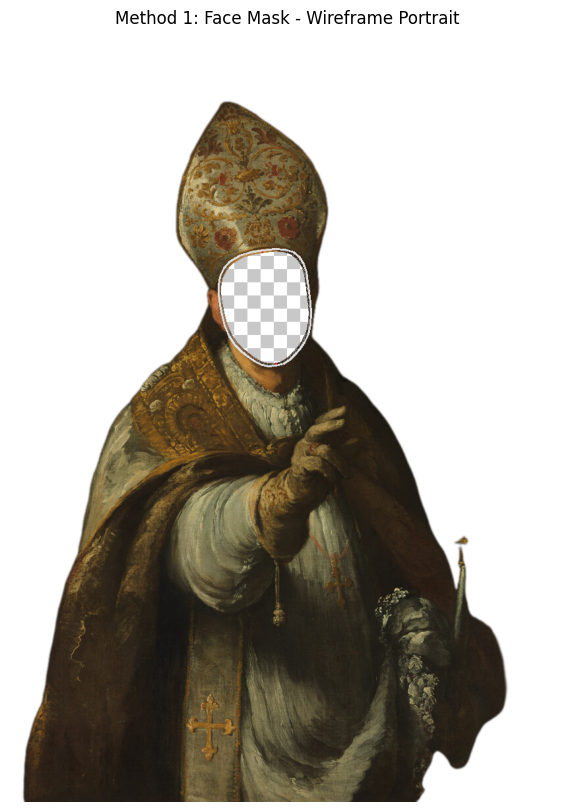

투명 픽셀: 17,775 / 985,467 (1.8%)

2️⃣ Color Difference 방법
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61→308): 2
✅ Color Difference 방법 사용 (threshold: 25)


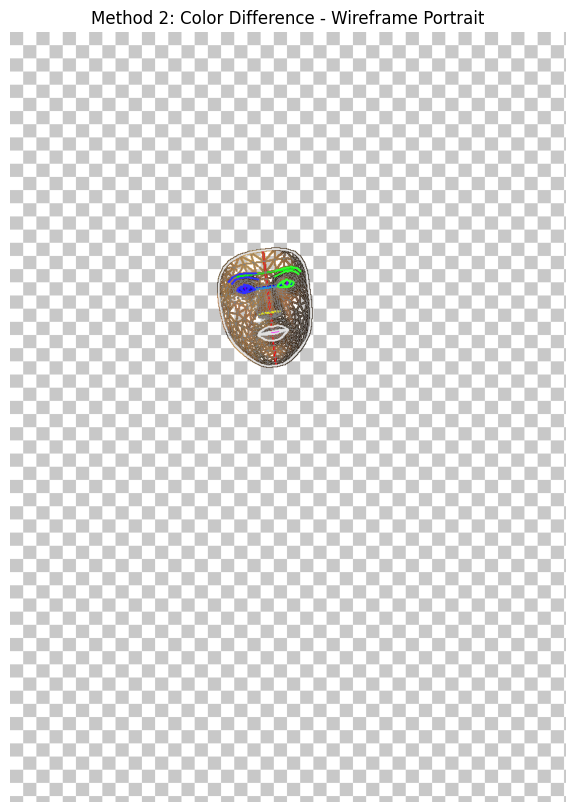

투명 픽셀: 966,413 / 985,467 (98.1%)

3️⃣ Color Filter 방법
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61→308): 2
✅ Color Filter 방법 사용 (tolerance: 30)


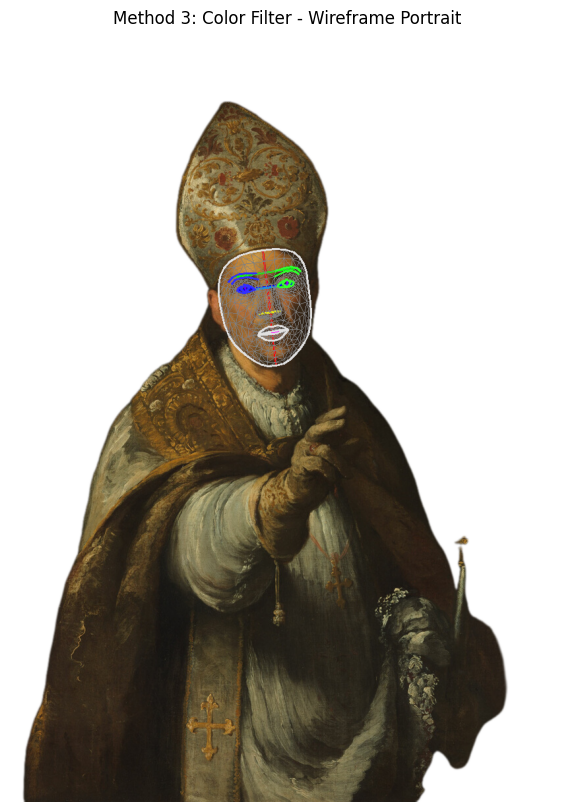

투명 픽셀: 0 / 985,467 (0.0%)

📊 결과 비교:
- Face Mask: 얼굴 형태 기반으로 정확한 마스킹
- Color Diff: 원본과의 차이 기반으로 선만 보존
- Color Filter: 특정 색상의 선들만 선별적으로 보존


In [130]:
# ==========================================
# Test and Compare All Methods
# ==========================================

print("🎨 Wireframe Portrait 생성 테스트 - 3가지 방법 비교")
print("="*60)

if detection_result.face_landmarks:
    # 1. Method 1: Face Mask-based
    print("\n1️⃣ Face Mask 방법")
    wireframe_mask, mask1, construction1, mesh1 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='face_mask'
    )
    show_rgba_image(wireframe_mask, "Method 1: Face Mask - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    # 2. Method 2: Color Difference-based
    print("\n2️⃣ Color Difference 방법")
    wireframe_diff, mask2, construction2, mesh2 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='color_diff', threshold=25
    )
    show_rgba_image(wireframe_diff, "Method 2: Color Difference - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    # 3. Method 3: Color Filtering-based
    print("\n3️⃣ Color Filter 방법")
    wireframe_filter, mask3, construction3, mesh3 = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='color_filter', tolerance=30
    )
    show_rgba_image(wireframe_filter, "Method 3: Color Filter - Wireframe Portrait", 
                   figsize=(14, 10), background_color='checkered')
    
    print("\n📊 결과 비교:")
    print("- Face Mask: 얼굴 형태 기반으로 정확한 마스킹")
    print("- Color Diff: 원본과의 차이 기반으로 선만 보존")
    print("- Color Filter: 특정 색상의 선들만 선별적으로 보존")
    
else:
    print("❌ 얼굴이 감지되지 않았습니다.")

🔧 최종 Wireframe Portrait 생성 및 저장

🎭 Face Mask 방법 (권장)
Vertical Center Line points: 4
Eyebrow Line points: 2
Eye Lines: 2, 2, 2, 2
Nose Line points: 2
Mouth Line points (61→308): 2
✅ Face Mask 방법 사용


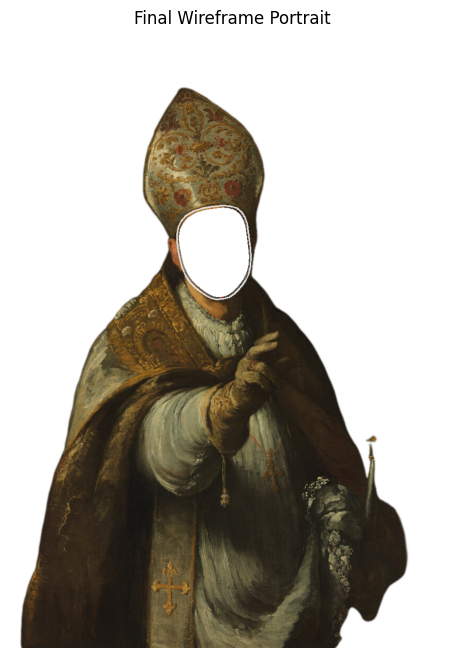

투명 픽셀: 17,775 / 985,467 (1.8%)
✅ 저장 완료: ../image_processing/out/portrait_wireframe.png

🖤 검은 배경에서의 모습:


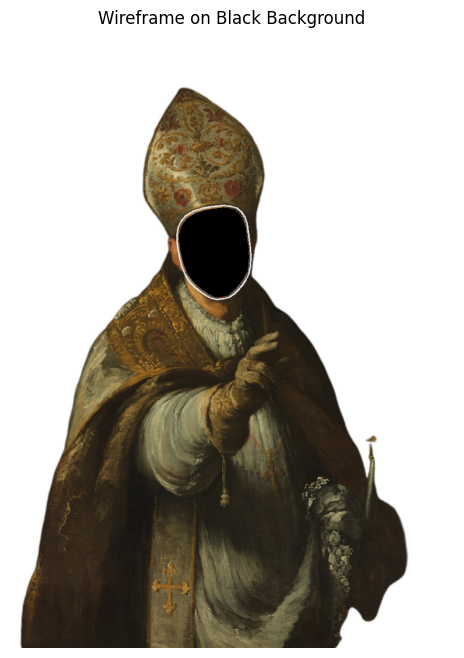

투명 픽셀: 17,775 / 985,467 (1.8%)

💡 사용 팁:
- Face Mask 방법이 가장 정확하고 일관된 결과를 제공합니다
- PNG 형태로 저장하면 투명도가 보존됩니다
- 다양한 배경에 합성할 수 있습니다
- 벡터 그래픽으로 변환하여 SVG로 저장도 가능합니다


In [131]:
# ==========================================
# Final Wireframe with Save Functionality
# ==========================================

print("🔧 최종 Wireframe Portrait 생성 및 저장")
print("="*40)

if detection_result.face_landmarks:
    # Face Mask 방법 (권장)
    print("\n🎭 Face Mask 방법 (권장)")
    wireframe_final, _, _, _ = create_wireframe_portrait(
        image_rgb, landmarks, detection_result, method='face_mask'
    )
    show_rgba_image(wireframe_final, "Final Wireframe Portrait", 
                   figsize=(12, 8), background_color='white')
    
    # 결과 저장
    save_wireframe_result(wireframe_final, "portrait_wireframe.png")
    
    # 다른 배경색으로도 확인
    print("\n🖤 검은 배경에서의 모습:")
    show_rgba_image(wireframe_final, "Wireframe on Black Background", 
                   figsize=(12, 8), background_color='black')
    
    print("\n" + "="*50)
    print("💡 사용 팁:")
    print("- Face Mask 방법이 가장 정확하고 일관된 결과를 제공합니다")
    print("- PNG 형태로 저장하면 투명도가 보존됩니다")
    print("- 다양한 배경에 합성할 수 있습니다")
    print("- 벡터 그래픽으로 변환하여 SVG로 저장도 가능합니다")
    
else:
    print("❌ 얼굴이 감지되지 않았습니다.")